# Segmentación de clientes de tarjetas de crédito

**Propósito:** El objetivo de este proyecto es agrupar clientes de tarjetas de crédito según su comportamiento de uso, pagos y compras, con el fin de identificar distintos perfiles financieros y obtener insights accionables para estrategias de retención y personalización.


## Objetivos específicos
- Identificar patrones de comportamiento financiero (compradores impulsivos, usuarios responsables, deudores frecuentes, etc.).
- Determinar variables que más influyen en la segmentación.
- Proponer estrategias de negocio basadas en los grupos detectados.

---

A continuación: carga del dataset, vista rápida (head), info, describe y revisión de valores faltantes.

## 1. Cargue de datos, rename de varibles

In [26]:
# Importar librerías principales y cargar el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pandas as pd
%matplotlib inline

# Cargar CSV
df = pd.read_csv('CC GENERAL.csv')

# Renombrar columnas a español
nombres_espanol = {
    'CUST_ID': 'ID_CLIENTE',
    'BALANCE': 'SALDO',
    'BALANCE_FREQUENCY': 'FRECUENCIA_SALDO',
    'PURCHASES': 'COMPRAS',
    'ONEOFF_PURCHASES': 'COMPRAS_UNICAS',
    'INSTALLMENTS_PURCHASES': 'COMPRAS_CUOTAS',
    'CASH_ADVANCE': 'ADELANTO_EFECTIVO',
    'PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS',
    'ONEOFF_PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS_UNICAS',
    'PURCHASES_INSTALLMENTS_FREQUENCY': 'FRECUENCIA_COMPRAS_CUOTAS',
    'CASH_ADVANCE_FREQUENCY': 'FRECUENCIA_ADELANTO_EFECTIVO',
    'CASH_ADVANCE_TRX': 'NUM_TRX_ADELANTO_EFECTIVO',
    'PURCHASES_TRX': 'NUM_TRX_COMPRAS',
    'CREDIT_LIMIT': 'LIMITE_CREDITO',
    'PAYMENTS': 'PAGOS',
    'MINIMUM_PAYMENTS': 'PAGOS_MINIMOS',
    'PRC_FULL_PAYMENT': 'PORC_PAGO_COMPLETO',
    'TENURE': 'ANTIGUEDAD'
}

df.rename(columns=nombres_espanol, inplace=True)

print('Info:')
display(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID_CLIENTE                    8950 non-null   object 
 1   SALDO                         8950 non-null   float64
 2   FRECUENCIA_SALDO              8950 non-null   float64
 3   COMPRAS                       8950 non-null   float64
 4   COMPRAS_UNICAS                8950 non-null   float64
 5   COMPRAS_CUOTAS                8950 non-null   float64
 6   ADELANTO_EFECTIVO             8950 non-null   float64
 7   FRECUENCIA_COMPRAS            8950 non-null   float64
 8   FRECUENCIA_COMPRAS_UNICAS     8950 non-null   float64
 9   FRECUENCIA_COMPRAS_CUOTAS     8950 non-null   float64
 10  FRECUENCIA_ADELANTO_EFECTIVO  8950 non-null   float64
 11  NUM_TRX_ADELANTO_EFECTIVO     8950 non-null   int64  
 12  NUM_TRX_COMPRAS               8950 non-null   int64  
 1

None

## Diccionario de Variables

El dataset contiene 18 variables de comportamiento de ~9,000 clientes durante 6 meses:

| Variable Original | Variable en Español | Descripción |
|-------------------|---------------------|-------------|
| `CUST_ID` | `ID_CLIENTE` | ID del titular de tarjeta |
| `BALANCE` | `SALDO` | Saldo disponible para compras |
| `BALANCE_FREQUENCY` | `FRECUENCIA_SALDO` | Frecuencia de actualización del saldo (0-1) |
| `PURCHASES` | `COMPRAS` | Monto total de compras |
| `ONEOFF_PURCHASES` | `COMPRAS_UNICAS` | Compra máxima en una transacción |
| `INSTALLMENTS_PURCHASES` | `COMPRAS_CUOTAS` | Compras en cuotas |
| `CASH_ADVANCE` | `ADELANTO_EFECTIVO` | Adelanto de efectivo |
| `PURCHASES_FREQUENCY` | `FRECUENCIA_COMPRAS` | Frecuencia de compras (0-1) |
| `ONEOFF_PURCHASES_FREQUENCY` | `FRECUENCIA_COMPRAS_UNICAS` | Frecuencia de compras únicas (0-1) |
| `PURCHASES_INSTALLMENTS_FREQUENCY` | `FRECUENCIA_COMPRAS_CUOTAS` | Frecuencia de compras en cuotas (0-1) |
| `CASH_ADVANCE_FREQUENCY` | `FRECUENCIA_ADELANTO_EFECTIVO` | Frecuencia de adelantos (0-1) |
| `CASH_ADVANCE_TRX` | `NUM_TRX_ADELANTO_EFECTIVO` | Número de transacciones de adelanto |
| `PURCHASES_TRX` | `NUM_TRX_COMPRAS` | Número de transacciones de compra |
| `CREDIT_LIMIT` | `LIMITE_CREDITO` | Límite de crédito |
| `PAYMENTS` | `PAGOS` | Monto de pagos |
| `MINIMUM_PAYMENTS` | `PAGOS_MINIMOS` | Pagos mínimos |
| `PRC_FULL_PAYMENT` | `PORC_PAGO_COMPLETO` | % de pago completo |
| `TENURE` | `ANTIGUEDAD` | Antigüedad del servicio (meses) |

## OVERVIEW

In [27]:
# Vista rápida del dataset
print('Shape:', df.shape)
display(df.head(10))

# Revisar valores faltantes por columna
print('\nMissing values:\n', df.isnull().sum().sort_values(ascending=False))
print('\nPorcentaje de missing values:\n', (df.isnull().sum() / len(df) * 100).sort_values(ascending=False))

Shape: (8950, 18)


,ID_CLIENTE,SALDO,FRECUENCIA_SALDO,COMPRAS,COMPRAS_UNICAS,COMPRAS_CUOTAS,ADELANTO_EFECTIVO,FRECUENCIA_COMPRAS,FRECUENCIA_COMPRAS_UNICAS,FRECUENCIA_COMPRAS_CUOTAS,FRECUENCIA_ADELANTO_EFECTIVO,NUM_TRX_ADELANTO_EFECTIVO,NUM_TRX_COMPRAS,LIMITE_CREDITO,PAGOS,PAGOS_MINIMOS,PORC_PAGO_COMPLETO,ANTIGUEDAD
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12
7,C10008,1823.652743,1.000000,436.20,0.00,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2300.0,679.065082,532.033990,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
9,C10010,152.225975,0.545455,1281.60,1281.60,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0,3,11000.0,1164.770591,100.302262,0.000000,12



Missing values:
 PAGOS_MINIMOS                   313
LIMITE_CREDITO                    1
SALDO                             0
ID_CLIENTE                        0
FRECUENCIA_SALDO                  0
COMPRAS                           0
ADELANTO_EFECTIVO                 0
FRECUENCIA_COMPRAS                0
COMPRAS_UNICAS                    0
COMPRAS_CUOTAS                    0
FRECUENCIA_COMPRAS_CUOTAS         0
FRECUENCIA_COMPRAS_UNICAS         0
NUM_TRX_ADELANTO_EFECTIVO         0
FRECUENCIA_ADELANTO_EFECTIVO      0
NUM_TRX_COMPRAS                   0
PAGOS                             0
PORC_PAGO_COMPLETO                0
ANTIGUEDAD                        0
dtype: int64

Porcentaje de missing values:
 PAGOS_MINIMOS                   3.497207
LIMITE_CREDITO                  0.011173
SALDO                           0.000000
ID_CLIENTE                      0.000000
FRECUENCIA_SALDO                0.000000
COMPRAS                         0.000000
ADELANTO_EFECTIVO               0.000000
FR

La columna ID_CLIENTE es un identificador único para cada cliente. No aporta información sobre el comportamiento del cliente, por lo que no es útil para el algoritmo de clustering y debe ser eliminada.

In [28]:
if 'ID_CLIENTE' in df.columns:
    df.drop('ID_CLIENTE', axis=1, inplace=True)
    print('Columna ID_CLIENTE eliminada correctamente.')
else:
    print('Columna ID_CLIENTE ya había sido eliminada.')

Columna ID_CLIENTE eliminada correctamente.


## Tratamiento de datos faltantes

La variable ¨PAGOS_MINIMOS¨ tiene al rededor de 300 datos nulos, los cuales imputaremos por medio de la media

In [43]:
df_eda = df.copy()
df_eda['PAGOS_MINIMOS'] = df_eda['PAGOS_MINIMOS'].fillna(df_eda['PAGOS_MINIMOS'].median())
df_eda['LIMITE_CREDITO'] = df_eda['LIMITE_CREDITO'].fillna(df_eda['LIMITE_CREDITO'].median())


## Ingeniería de características exploratoria

Creamos variables derivadas que resuman el uso del crédito y los patrones de pago antes de profundizar en las relaciones clave.

In [ ]:
# Ingeniería de características para análisis
epsilon = 1e-6
df_eda = df_eda.assign(
    TASA_UTILIZACION_CREDITO=lambda x: np.clip(x['SALDO'] / (x['LIMITE_CREDITO'].replace(0, np.nan)), 0, 5),
    RATIO_PAGOS_MINIMOS=lambda x: np.clip(x['PAGOS_MINIMOS'] / (x['PAGOS'] + epsilon), 0, 2),
    RATIO_PAGOS_COMPRAS=lambda x: np.clip(x['PAGOS'] / (x['COMPRAS'] + epsilon), 0, 3),
    INTENSIDAD_ADELANTO=lambda x: np.clip(x['ADELANTO_EFECTIVO'] / (x['LIMITE_CREDITO'] + epsilon), 0, 5)
)
display(df_eda[['TASA_UTILIZACION_CREDITO','RATIO_PAGOS_MINIMOS','RATIO_PAGOS_COMPRAS','INTENSIDAD_ADELANTO']].describe().T)

In [29]:
# Resumen de valores faltantes en el dataset original (sin transformaciones)
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)

print("Valores nulos por columna en df (datos originales):")
display(pd.DataFrame({"Nulos": missing_counts, "% del total": missing_pct}))

Valores nulos por columna en df (datos originales):


,Nulos,% del total
PAGOS_MINIMOS,313,3.50
LIMITE_CREDITO,1,0.01
SALDO,0,0.00
FRECUENCIA_SALDO,0,0.00
COMPRAS,0,0.00
ADELANTO_EFECTIVO,0,0.00
FRECUENCIA_COMPRAS,0,0.00
COMPRAS_UNICAS,0,0.00
COMPRAS_CUOTAS,0,0.00
FRECUENCIA_COMPRAS_CUOTAS,0,0.00


### Distribuciones de variables numéricas

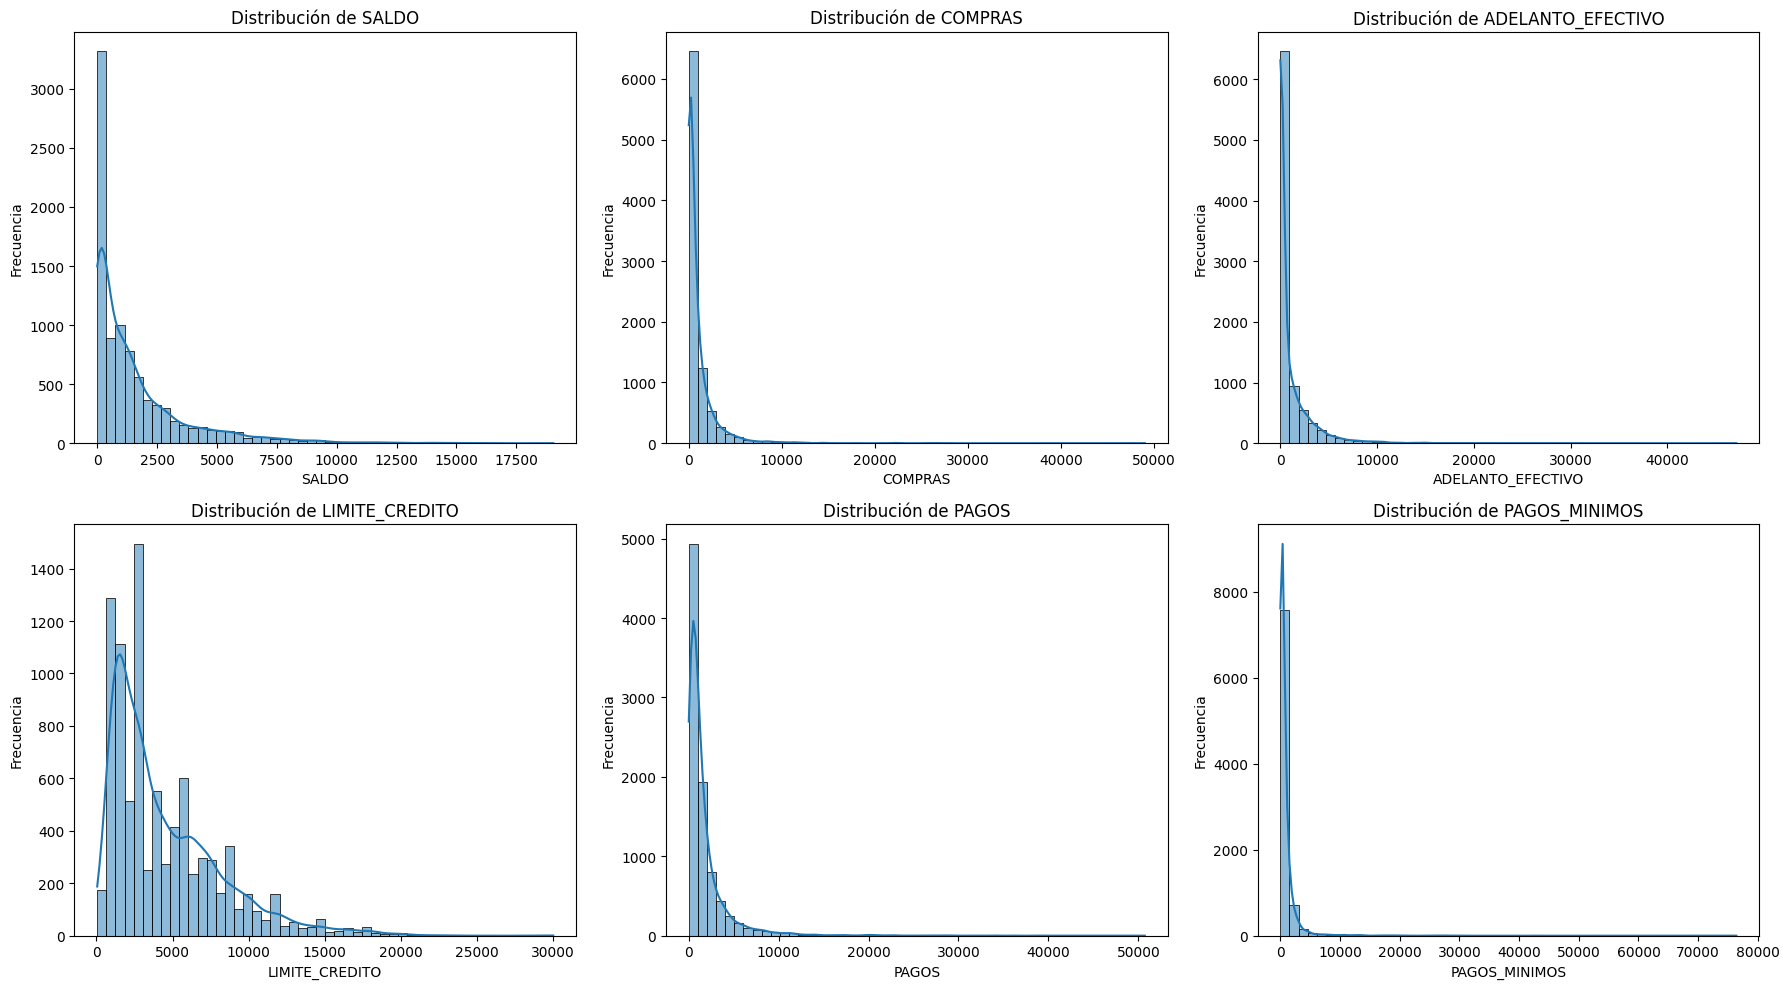

In [30]:
# Histogramas para variables clave
variables_clave = ['SALDO', 'COMPRAS', 'ADELANTO_EFECTIVO', 'LIMITE_CREDITO', 'PAGOS', 'PAGOS_MINIMOS']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables_clave):
    sns.histplot(df[var].dropna(), bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

## Transformaciones para variables sesgadas

Aplicamos escalas logarítmicas a montos altamente sesgados para entender mejor la densidad de clientes en cada rango de valor.

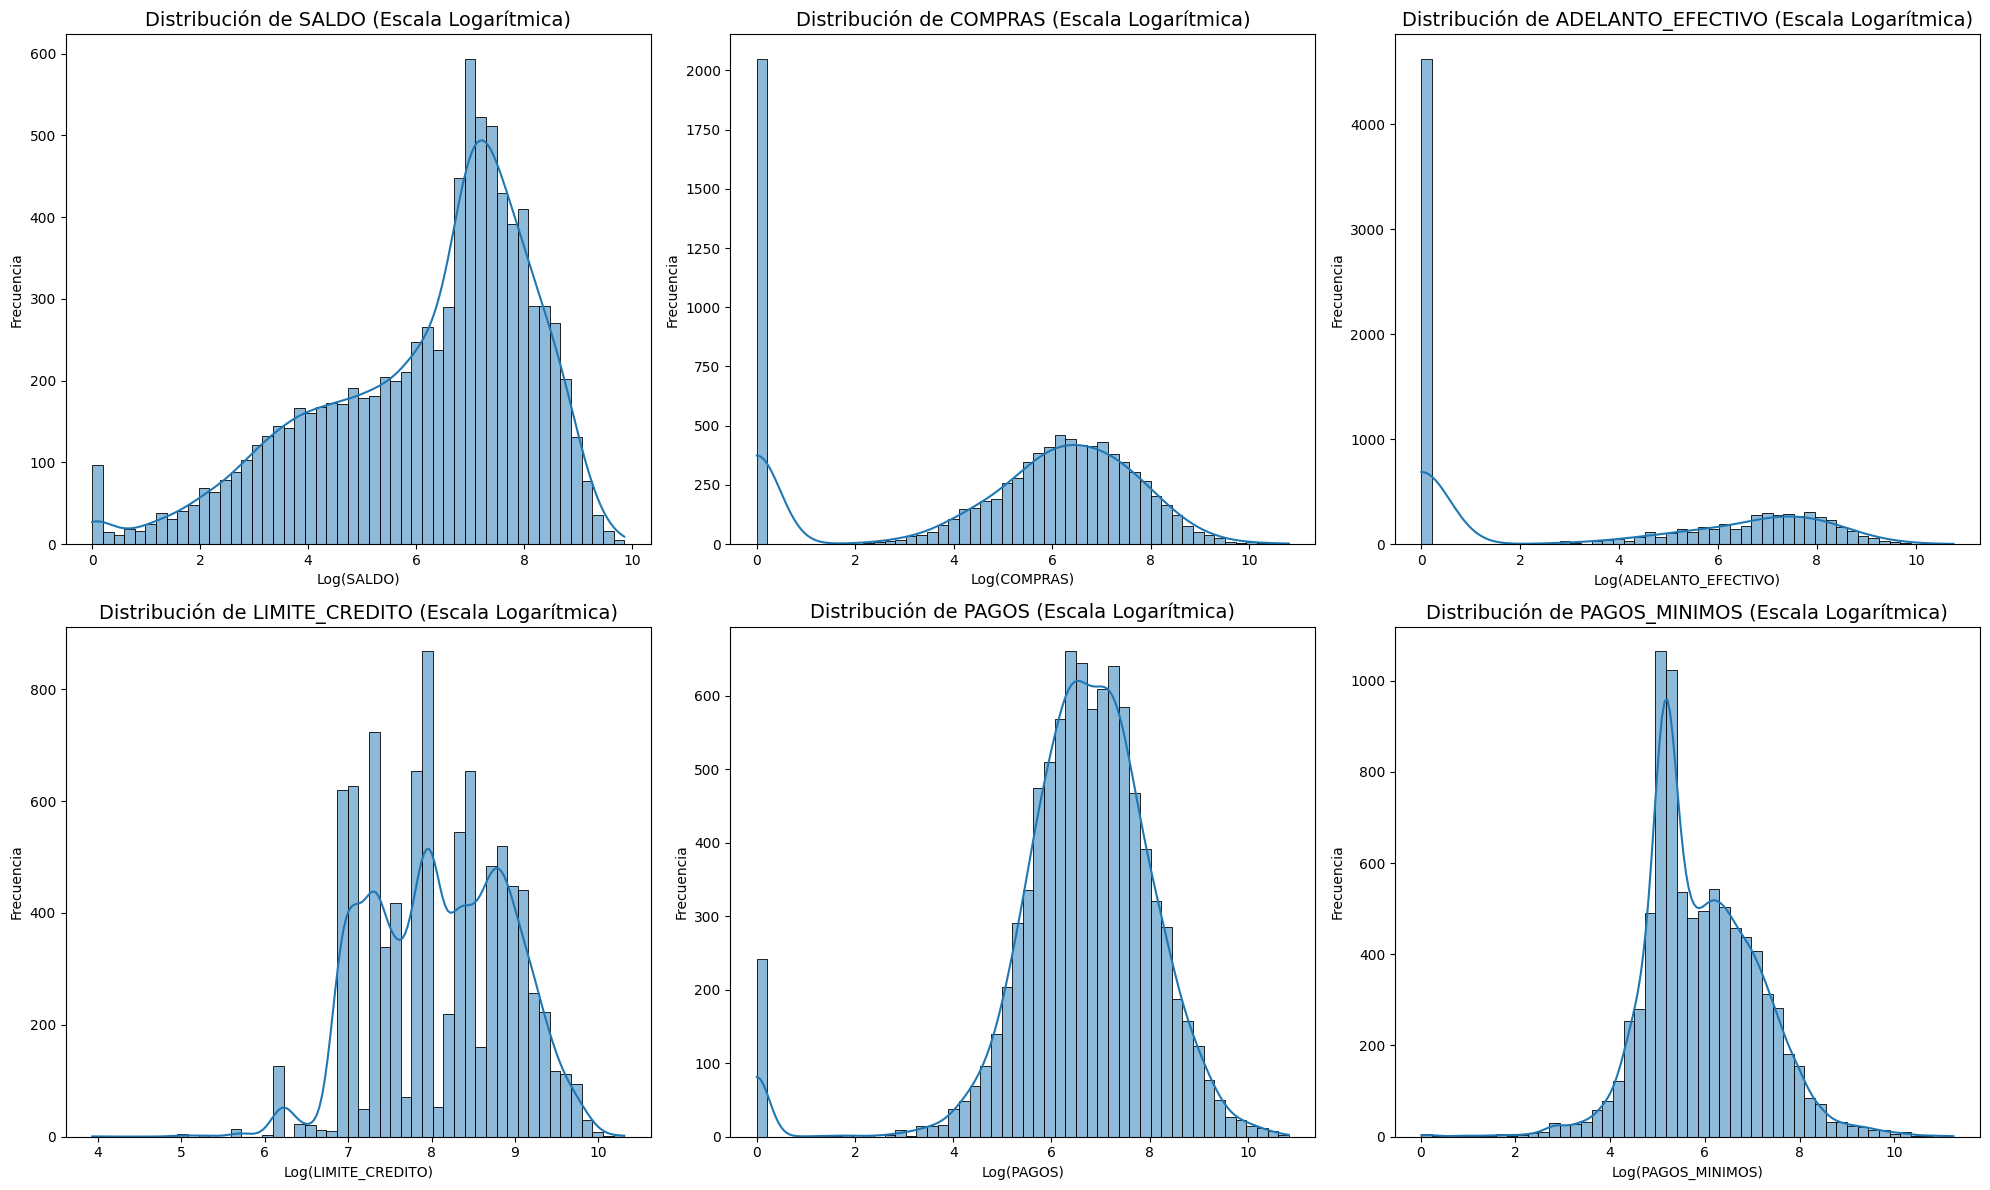

In [33]:
# Aplicamos la transformación logarítmica (log1p) para la visualización
# Creamos un nuevo DataFrame para no alterar el df
df_log = df[variables_clave].apply(np.log1p)

# Volvemos a crear los histogramas con los datos transformados
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables_clave):
    sns.histplot(data=df_log, x=var, bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribución de {var} (Escala Logarítmica)', fontsize=14)
    axes[i].set_xlabel(f'Log({var})')
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

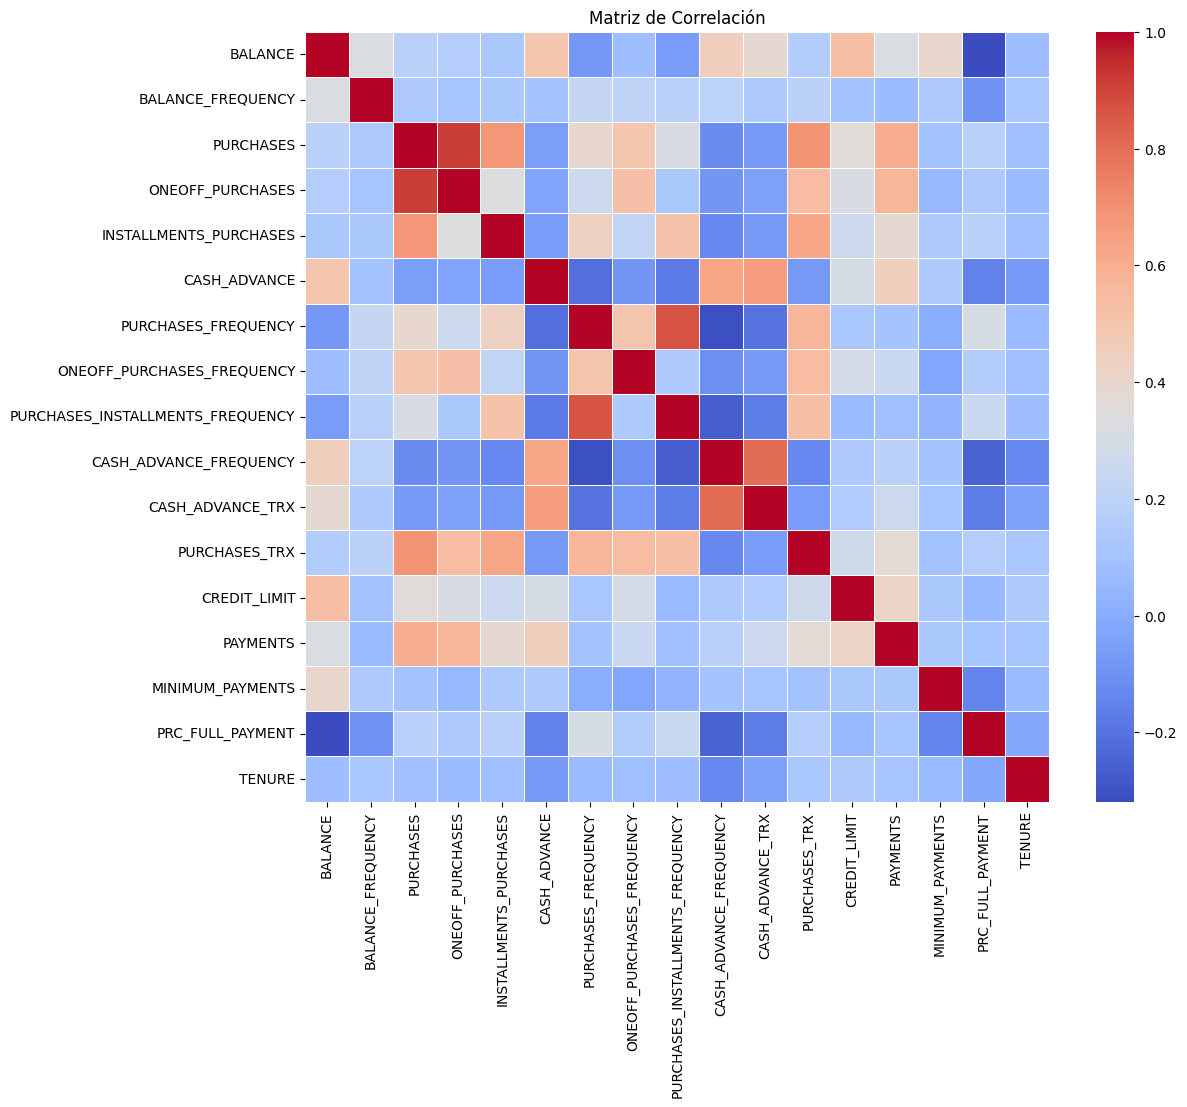

Pares con correlación alta (|corr| > 0.5):


,Var1,Var2,Corr
31,PURCHASES,ONEOFF_PURCHASES,0.916845
82,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,0.862934
108,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,0.799561
39,PURCHASES,PURCHASES_TRX,0.689561
32,PURCHASES,INSTALLMENTS_PURCHASES,0.679896
74,CASH_ADVANCE,CASH_ADVANCE_TRX,0.656498
73,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,0.628522
64,INSTALLMENTS_PURCHASES,PURCHASES_TRX,0.628108
41,PURCHASES,PAYMENTS,0.603264
85,PURCHASES_FREQUENCY,PURCHASES_TRX,0.568430


In [ ]:
# Matriz de correlación (incluye variables derivadas)
numeric_cols_eda = df_eda.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
corr_matrix = df_eda[numeric_cols_eda].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación - variables originales y derivadas')
plt.show()

# Correlaciones más altas (abs > 0.5)
high_corr = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Var1', 'Var2', 'Corr']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Corr'].abs() > 0.5].sort_values('Corr', ascending=False)
print('Pares con correlación alta (|corr| > 0.5):')
display(high_corr_pairs)

## Relaciones clave entre variables
Investigamos los pares destacados por el área de negocio para entender patrones de comportamiento y riesgo.

In [ ]:
# Visualización de relaciones clave con regresiones
rel_cols = ['SALDO','PAGOS','ADELANTO_EFECTIVO','LIMITE_CREDITO','FRECUENCIA_COMPRAS','PORC_PAGO_COMPLETO']
sample_rel = df_eda[rel_cols].dropna().sample(n=min(5000, len(df_eda)), random_state=42)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.regplot(data=sample_rel, x='SALDO', y='PAGOS', ax=axes[0], scatter_kws={'alpha':0.25, 's':15}, line_kws={'color':'crimson'})
axes[0].set_title('SALDO vs PAGOS', fontsize=12)
axes[0].set_xlabel('Saldo')
axes[0].set_ylabel('Pagos')
sns.regplot(x=np.log1p(sample_rel['ADELANTO_EFECTIVO']), y=np.log1p(sample_rel['LIMITE_CREDITO']), ax=axes[1], scatter_kws={'alpha':0.25, 's':15}, line_kws={'color':'darkgreen'})
axes[1].set_title('log(ADELANTO_EFECTIVO) vs log(LIMITE_CREDITO)', fontsize=12)
axes[1].set_xlabel('log(Adelanto de efectivo + 1)')
axes[1].set_ylabel('log(Límite de crédito + 1)')
sns.regplot(data=sample_rel, x='FRECUENCIA_COMPRAS', y='PORC_PAGO_COMPLETO', lowess=True, ax=axes[2], scatter_kws={'alpha':0.25, 's':15}, line_kws={'color':'navy'})
axes[2].set_title('Frecuencia de compras vs % de pago completo', fontsize=12)
axes[2].set_xlabel('Frecuencia de compras')
axes[2].set_ylabel('% pago completo')
plt.tight_layout()
plt.show()

### Perfil de riesgo basado en utilización y pagos

Combinamos los indicadores derivados para detectar segmentos de clientes potencialmente riesgosos.

In [ ]:
# Clasificación simple de riesgo para exploración
util_high = df_eda['TASA_UTILIZACION_CREDITO'].quantile(0.85)
ratio_min_high = df_eda['RATIO_PAGOS_MINIMOS'].quantile(0.65)
df_eda['FLAG_RIESGO'] = np.where(
    (df_eda['TASA_UTILIZACION_CREDITO'] > util_high) &
    (df_eda['RATIO_PAGOS_MINIMOS'] > ratio_min_high) &
    (df_eda['FRECUENCIA_COMPRAS'] > 0.5),
    'Riesgo alto',
    'Riesgo moderado/bajo'
 )
resumen_riesgo = df_eda.groupby('FLAG_RIESGO')[['SALDO','PAGOS','COMPRAS','TASA_UTILIZACION_CREDITO','RATIO_PAGOS_MINIMOS']].agg(['mean','median'])
display(resumen_riesgo)
print(f"Clientes clasificados como riesgo alto: {df_eda['FLAG_RIESGO'].eq('Riesgo alto').mean():.1%}")

#### Mapa de calor de riesgo relativo

Observamos cómo interactúan los tramos de utilización versus la proporción de pago mínimo para identificar zonas de preocupación.

In [ ]:
df_eda['BIN_UTILIZACION'] = pd.qcut(
    df_eda['TASA_UTILIZACION_CREDITO'].fillna(0),
    q=4,
    labels=['Muy baja','Baja','Media','Alta'],
    duplicates='drop'
 )
df_eda['BIN_PAGO_MINIMO'] = pd.qcut(
    df_eda['RATIO_PAGOS_MINIMOS'].fillna(0),
    q=4,
    labels=['Muy bajo','Bajo','Medio','Alto'],
    duplicates='drop'
 )
pivot_riesgo = df_eda.pivot_table(
    index='BIN_UTILIZACION',
    columns='BIN_PAGO_MINIMO',
    values='SALDO',
    aggfunc='mean'
 ).sort_index().sort_index(axis=1)
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_riesgo, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Saldo promedio por nivel de utilización y pago mínimo')
plt.xlabel('Proporción de pago mínimo')
plt.ylabel('Utilización del crédito')
plt.tight_layout()
plt.show()